In [4]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})
from scipy import stats

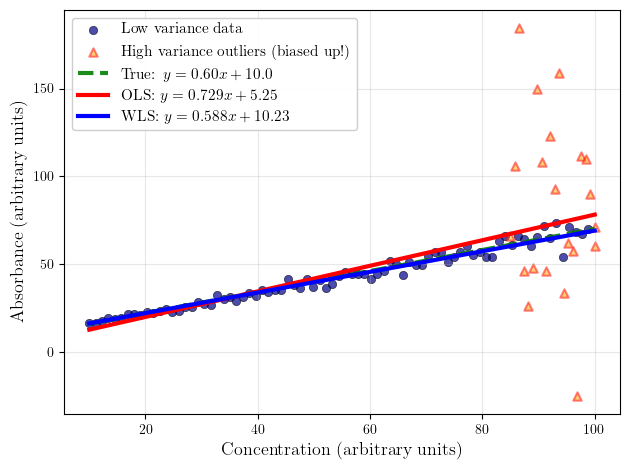

In [ ]:
np.random.seed(42)

n = 80
x = np.linspace(10, 100, n)

# true relationship: y = 0.6 * x + 10
true_slope = 0.6
true_intercept = 10
y_true = true_slope * x + true_intercept

# add heteroscedastic noise that increases dramatically with x
noise_std = 0.05 * x
noise = np.random.normal(0, noise_std)
y = y_true + noise

# add systematically biased high-variance points at high x values
# these will pull OLS strongly but WLS will down-weight them
n_outliers = 20
x_outliers = np.linspace(85, 100, n_outliers)
noise_std_outliers = 0.8 * x_outliers

# bias all the outliers upward to pull OLS slope up
bias = 20
noise_outliers = np.random.normal(bias, noise_std_outliers)
y_outliers = true_slope * x_outliers + true_intercept + noise_outliers

x_combined = np.concatenate([x, x_outliers])
y_combined = np.concatenate([y, y_outliers])
noise_std_combined = np.concatenate([noise_std, noise_std_outliers])

sort_idx = np.argsort(x_combined)
x_combined = x_combined[sort_idx]
y_combined = y_combined[sort_idx]
noise_std_combined = noise_std_combined[sort_idx]

# OLS
ols_slope, ols_intercept, _, _, _ = stats.linregress(x_combined, y_combined)
y_ols = ols_slope * x_combined + ols_intercept

# WLS
weights = 1 / (noise_std_combined ** 2)
W = np.diag(weights)
X = np.column_stack([np.ones(len(x_combined)), x_combined])
wls_params = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y_combined)
wls_intercept, wls_slope = wls_params
y_wls = wls_slope * x_combined + wls_intercept

plt.figure()

low_var_mask = noise_std_combined < 5
high_var_mask = ~low_var_mask

plt.scatter(x_combined[low_var_mask], y_combined[low_var_mask], 
           alpha=0.7, c='darkblue', label='Low variance data', 
           edgecolors='black', linewidth=0.5)
plt.scatter(x_combined[high_var_mask], y_combined[high_var_mask], 
           alpha=0.5, c='orange', label='High variance outliers (biased up!)', 
           edgecolors='red', linewidth=1.5, marker='^')

plt.plot(x_combined, true_slope * x_combined + true_intercept, 
         'g--', linewidth=3, label=fr'True: $y = {true_slope:.2f}x + {true_intercept:.1f}$', alpha=0.9)
plt.plot(x_combined, y_ols, 'r-', linewidth=3, 
         label=fr'OLS: $y = {ols_slope:.3f}x + {ols_intercept:.2f}$')
plt.plot(x_combined, y_wls, 'b-', linewidth=3, 
         label=fr'WLS: $y = {wls_slope:.3f}x + {wls_intercept:.2f}$')

plt.xlabel('Concentration (arbitrary units)', fontsize=13)
plt.ylabel('Absorbance (arbitrary units)', fontsize=13)
plt.legend(fontsize=11, loc='upper left', framealpha=0.95)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig("../../../figs/models-vs-data/ols_wls.pdf", bbox_inches="tight", transparent=True)

plt.show()